In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(3*n/5)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 100

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return -sum(ens).real
    return gamma_beta_objective, history



/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

<ipython-input-4-3a2e1d7ccf7f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


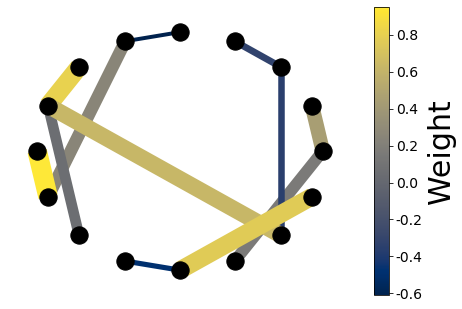

In [4]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [10+10*weights.get(edge, weights.get((edge[1], edge[0]))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [5]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


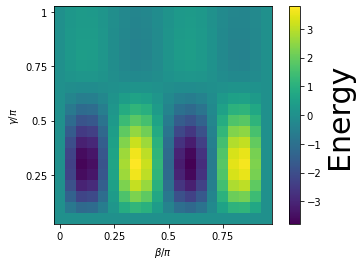

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [25]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.25*np.pi,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [34]:
from tqdm import tqdm
MAX_ITERATION = 200
shots_per_point = BASELINE_SHOTS
fit_func1, history = expectation_objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [35]:
history, result = test_solver(oes)


  0%|          | 1/200 [00:00<03:00,  1.10it/s]

(array([ 1.82829023, -0.94565388]), 3.179839973214408, 3.179839973214408, 0.7853981633974483)


  1%|          | 2/200 [00:01<03:02,  1.09it/s]

(array([ 0.39680285, -0.17341817]), 1.264577195068219, 1.264577195068219, 0.7853981633974483)


  2%|▏         | 3/200 [00:02<03:00,  1.09it/s]

(array([ 0.565137  , -0.96317641]), 2.8408402924346396, 2.8408402924346396, 0.7853981633974483)


  2%|▏         | 4/200 [00:03<03:05,  1.05it/s]

(array([-0.41764176,  0.60849142]), 3.4879441040144243, 3.4879441040144243, 0.7853981633974483)


  2%|▎         | 5/200 [00:04<03:02,  1.07it/s]

(array([-0.9782494, -1.0399795]), 2.460660753516583, 2.460660753516583, 0.7853981633974483)


  3%|▎         | 6/200 [00:05<03:02,  1.06it/s]

(array([-0.58484813,  0.73407039]), 2.6944655815751926, 2.6944655815751926, 0.7853981633974483)


  4%|▎         | 7/200 [00:06<03:01,  1.07it/s]

(array([ 0.23872163, -0.50121977]), 2.562458219011624, 2.562458219011624, 0.7853981633974483)


  4%|▍         | 8/200 [00:07<03:00,  1.06it/s]

(array([ 0.4802146 , -0.60031393]), 3.2713268006619254, 3.2713268006619254, 0.7853981633974483)


  4%|▍         | 9/200 [00:08<02:57,  1.08it/s]

(array([ 0.27181317, -0.67790361]), 3.2445443357839023, 3.2445443357839023, 0.7853981633974483)


  5%|▌         | 10/200 [00:09<02:59,  1.06it/s]

(array([1.01071489, 0.73095736]), 2.93615068052328, 2.93615068052328, 0.7853981633974483)


  6%|▌         | 11/200 [00:10<02:56,  1.07it/s]

(array([-0.60935646,  1.13688512]), 2.1108956976820172, 2.1108956976820172, 0.7853981633974483)


  6%|▌         | 12/200 [00:11<02:54,  1.08it/s]

(array([1.28409533, 0.70280783]), 3.378483944773442, 3.378483944773442, 0.7853981633974483)


  6%|▋         | 13/200 [00:12<02:50,  1.09it/s]

(array([ 0.48298924, -0.73281913]), 3.504981408041509, 3.504981408041509, 0.7853981633974483)


  7%|▋         | 14/200 [00:13<02:50,  1.09it/s]

(array([ 0.34873243, -0.11053157]), 0.8033547085810863, 0.8033547085810863, 0.7853981633974483)


  8%|▊         | 15/200 [00:14<02:54,  1.06it/s]

(array([1.28806191, 0.4263596 ]), 2.5356253228761623, 2.5356253228761623, 0.7853981633974483)


  8%|▊         | 16/200 [00:14<02:53,  1.06it/s]

(array([ 0.37303986, -0.2506403 ]), 1.7821177161505093, 1.7821177161505093, 0.7853981633974483)


  8%|▊         | 17/200 [00:15<02:52,  1.06it/s]

(array([-1.21092942, -0.44553117]), 2.869770581065942, 2.869770581065942, 0.7853981633974483)


  9%|▉         | 18/200 [00:16<02:52,  1.06it/s]

(array([-0.23446475,  0.48904548]), 2.4905647128192014, 2.4905647128192014, 0.7853981633974483)


 10%|▉         | 19/200 [00:17<02:57,  1.02it/s]

(array([ 0.49236634, -0.53747859]), 3.0217973497784714, 3.0217973497784714, 0.7853981633974483)


 10%|█         | 20/200 [00:18<02:53,  1.03it/s]

(array([ 0.28478686, -0.69582792]), 3.3567495175903197, 3.3567495175903197, 0.7853981633974483)


 10%|█         | 21/200 [00:19<02:56,  1.01it/s]

(array([ 0.4883474 , -0.17808451]), 1.2035352413973603, 1.2035352413973603, 0.7853981633974483)


 11%|█         | 22/200 [00:20<02:52,  1.03it/s]

(array([-0.59180461,  0.54711901]), 2.3169348612264318, 2.3169348612264318, 0.7853981633974483)


 12%|█▏        | 23/200 [00:21<02:56,  1.00it/s]

(array([1.01488832, 0.45277517]), 2.326313620034382, 2.326313620034382, 0.7853981633974483)


 12%|█▏        | 24/200 [00:23<03:06,  1.06s/it]

(array([ 0.5120169 , -0.69949891]), 3.2879331360409916, 3.2879331360409916, 0.7853981633974483)


 12%|█▎        | 25/200 [00:24<03:07,  1.07s/it]

(array([-0.43222545,  0.55282735]), 3.291641053623626, 3.291641053623626, 0.7853981633974483)


 13%|█▎        | 26/200 [00:25<03:03,  1.06s/it]

(array([-0.42278455,  1.01698123]), 3.5556109503683673, 3.5556109503683673, 0.7853981633974483)


 14%|█▎        | 27/200 [00:26<02:57,  1.03s/it]

(array([ 0.37642008, -0.81920151]), 3.7897068565818155, 3.7897068565818155, 0.7853981633974483)


 14%|█▍        | 28/200 [00:27<03:00,  1.05s/it]

(array([-0.57428792,  0.73807898]), 2.8053739184061395, 2.8053739184061395, 0.7853981633974483)


 14%|█▍        | 29/200 [00:28<03:03,  1.07s/it]

(array([-0.9700127 , -0.31666167]), 1.481902399271071, 1.481902399271071, 0.7853981633974483)


 15%|█▌        | 30/200 [00:29<03:00,  1.06s/it]

(array([ 0.40237624, -0.51658604]), 3.1980233846149906, 3.1980233846149906, 0.7853981633974483)


 16%|█▌        | 31/200 [00:30<03:07,  1.11s/it]

(array([-0.26313989,  0.67279404]), 3.175146369066872, 3.175146369066872, 0.7853981633974483)


 16%|█▌        | 32/200 [00:31<03:10,  1.13s/it]

(array([-0.55286495,  0.6165528 ]), 2.8276382091275822, 2.8276382091275822, 0.7853981633974483)


 16%|█▋        | 33/200 [00:32<02:59,  1.08s/it]

(array([-0.37117602,  0.76680319]), 3.7640394955743193, 3.7640394955743193, 0.7853981633974483)


 17%|█▋        | 34/200 [00:33<02:53,  1.05s/it]

(array([-1.06276155, -0.55040682]), 2.977253984577217, 2.977253984577217, 0.7853981633974483)


 18%|█▊        | 35/200 [00:34<02:48,  1.02s/it]

(array([-0.49991517,  0.54942567]), 3.020642313522669, 3.020642313522669, 0.7853981633974483)


 18%|█▊        | 36/200 [00:35<02:44,  1.00s/it]

(array([ 0.57018315, -0.7059552 ]), 2.8147664472068272, 2.8147664472068272, 0.7853981633974483)


 18%|█▊        | 37/200 [00:36<02:44,  1.01s/it]

(array([ 0.54447306, -1.08766109]), 2.798108774227679, 2.798108774227679, 0.7853981633974483)


 19%|█▉        | 38/200 [00:37<02:46,  1.03s/it]

(array([ 2.11484082, -0.81067428]), 3.1221158496816694, 3.1221158496816694, 0.7853981633974483)


 20%|█▉        | 39/200 [00:38<02:42,  1.01s/it]

(array([-1.20479546, -0.40719093]), 2.690680389845474, 2.690680389845474, 0.7853981633974483)


 20%|██        | 40/200 [00:39<02:39,  1.00it/s]

(array([-0.05743327,  1.27474645]), 0.6299443460663879, 0.6299443460663879, 0.7853981633974483)


 20%|██        | 41/200 [00:40<02:36,  1.02it/s]

(array([ 0.21294198, -0.89270636]), 2.8358451144938885, 2.8358451144938885, 0.7853981633974483)


 21%|██        | 42/200 [00:41<02:32,  1.04it/s]

(array([-0.27307934,  0.43553222]), 2.527317246120467, 2.527317246120467, 0.7853981633974483)


 22%|██▏       | 43/200 [00:42<02:34,  1.02it/s]

(array([ 0.39706927, -0.62988479]), 3.5605398852422163, 3.5605398852422163, 0.7853981633974483)


 22%|██▏       | 44/200 [00:43<02:37,  1.01s/it]

(array([1.16515736, 0.53435819]), 3.2631715147747506, 3.2631715147747506, 0.7853981633974483)


 22%|██▎       | 45/200 [00:44<02:38,  1.02s/it]

(array([ 0.41570376, -0.59075145]), 3.440136795635234, 3.440136795635234, 0.7853981633974483)


 23%|██▎       | 46/200 [00:45<02:40,  1.04s/it]

(array([-0.53302327,  0.70978971]), 3.1467162071052712, 3.1467162071052712, 0.7853981633974483)


 24%|██▎       | 47/200 [00:47<02:57,  1.16s/it]

(array([ 0.2866926 , -0.55876192]), 3.056441759916543, 3.056441759916543, 0.7853981633974483)


 24%|██▍       | 48/200 [00:48<03:05,  1.22s/it]

(array([ 0.45852207, -0.52960321]), 3.1379648556209374, 3.1379648556209374, 0.7853981633974483)


 24%|██▍       | 49/200 [00:50<03:14,  1.29s/it]

(array([ 0.73211332, -0.74640533]), 0.7955594098911473, 0.7955594098911473, 0.7853981633974483)


 25%|██▌       | 50/200 [00:51<03:11,  1.27s/it]

(array([-0.28673518,  0.59746537]), 3.166934228156645, 3.166934228156645, 0.7853981633974483)


 26%|██▌       | 51/200 [00:52<03:11,  1.29s/it]

(array([ 0.27278107, -0.32448879]), 1.9944125827751735, 1.9944125827751735, 0.7853981633974483)


 26%|██▌       | 52/200 [00:53<03:02,  1.24s/it]

(array([ 0.26874962, -0.9182595 ]), 3.2931493309905853, 3.2931493309905853, 0.7853981633974483)


 26%|██▋       | 53/200 [00:54<02:52,  1.17s/it]

(array([-0.36473174,  0.94418653]), 3.6880637627477335, 3.6880637627477335, 0.7853981633974483)


 27%|██▋       | 54/200 [00:55<02:46,  1.14s/it]

(array([-0.43545591,  0.83633549]), 3.7414235626896577, 3.7414235626896577, 0.7853981633974483)


 28%|██▊       | 55/200 [00:56<02:36,  1.08s/it]

(array([1.06554264, 0.95691827]), 3.3245759257263288, 3.3245759257263288, 0.7853981633974483)


 28%|██▊       | 56/200 [00:57<02:28,  1.03s/it]

(array([-0.13923415,  0.89282139]), 1.9921116552614873, 1.9921116552614873, 0.7853981633974483)


 28%|██▊       | 57/200 [00:58<02:26,  1.03s/it]

(array([-0.16146246,  0.52604561]), 1.948052760992034, 1.948052760992034, 0.7853981633974483)


 29%|██▉       | 58/200 [01:00<02:37,  1.11s/it]

(array([ 0.41709716, -0.8119988 ]), 3.7790055718480833, 3.7790055718480833, 0.7853981633974483)


 30%|██▉       | 59/200 [01:01<02:32,  1.08s/it]

(array([-0.21718148,  1.23290679]), 2.235042998806523, 2.235042998806523, 0.7853981633974483)


 30%|███       | 60/200 [01:02<02:34,  1.10s/it]

(array([ 0.27597722, -0.75594741]), 3.36617265724223, 3.36617265724223, 0.7853981633974483)


 30%|███       | 61/200 [01:03<02:30,  1.08s/it]

(array([ 0.36680571, -1.09979821]), 3.3545007160656795, 3.3545007160656795, 0.7853981633974483)


 31%|███       | 62/200 [01:04<02:26,  1.06s/it]

(array([-0.31974578,  1.18739546]), 2.961599724615762, 2.961599724615762, 0.7853981633974483)


 32%|███▏      | 63/200 [01:05<02:20,  1.02s/it]

(array([-0.21735948,  1.01828901]), 2.7340046438769536, 2.7340046438769536, 0.7853981633974483)


 32%|███▏      | 64/200 [01:06<02:14,  1.01it/s]

(array([-0.95806008, -0.79775468]), 2.416809684456867, 2.416809684456867, 0.7853981633974483)


 32%|███▎      | 65/200 [01:07<02:12,  1.02it/s]

(array([-0.09679676,  0.25304421]), 0.6808985286376323, 0.6808985286376323, 0.7853981633974483)


 33%|███▎      | 66/200 [01:08<02:12,  1.01it/s]

(array([1.20141668, 0.99731538]), 3.6061137645744514, 3.6061137645744514, 0.7853981633974483)


 34%|███▎      | 67/200 [01:09<02:11,  1.01it/s]

(array([-0.28168757,  0.62183984]), 3.197436885773855, 3.197436885773855, 0.7853981633974483)


 34%|███▍      | 68/200 [01:09<02:09,  1.02it/s]

(array([-0.41706208,  1.12058051]), 3.2953901046976153, 3.2953901046976153, 0.7853981633974483)


 34%|███▍      | 69/200 [01:10<02:07,  1.02it/s]

(array([ 0.07782589, -0.17691596]), 0.3948766198594646, 0.3948766198594646, 0.7853981633974483)


 35%|███▌      | 70/200 [01:11<02:06,  1.03it/s]

(array([-0.52383167,  0.64774589]), 3.118691432489215, 3.118691432489215, 0.7853981633974483)


 36%|███▌      | 71/200 [01:12<02:08,  1.01it/s]

(array([-0.39371708,  0.44160208]), 2.8760830408820963, 2.8760830408820963, 0.7853981633974483)


 36%|███▌      | 72/200 [01:13<02:05,  1.02it/s]

(array([-1.19125079, -0.53584048]), 3.2684433734673277, 3.2684433734673277, 0.7853981633974483)


 36%|███▋      | 73/200 [01:14<02:05,  1.01it/s]

(array([-0.35321247,  0.74829497]), 3.715953596837212, 3.715953596837212, 0.7853981633974483)


 37%|███▋      | 74/200 [01:16<02:10,  1.03s/it]

(array([-0.56349537,  0.69466335]), 2.864818057944707, 2.864818057944707, 0.7853981633974483)


 38%|███▊      | 75/200 [01:17<02:15,  1.08s/it]

(array([1.19186007, 0.7786071 ]), 3.7797463175615715, 3.7797463175615715, 0.7853981633974483)


 38%|███▊      | 76/200 [01:18<02:13,  1.08s/it]

(array([ 0.67100566, -0.82526211]), 1.6777670630330621, 1.6777670630330621, 0.7853981633974483)


 38%|███▊      | 77/200 [01:19<02:09,  1.06s/it]

(array([ 0.37142518, -0.84439928]), 3.7814058570191627, 3.7814058570191627, 0.7853981633974483)


 39%|███▉      | 78/200 [01:20<02:04,  1.02s/it]

(array([-0.43918624,  0.79057106]), 3.7258821017388257, 3.7258821017388257, 0.7853981633974483)


 40%|███▉      | 79/200 [01:21<02:00,  1.01it/s]

(array([ 0.57991986, -0.45461274]), 2.1512109987190327, 2.1512109987190327, 0.7853981633974483)


 40%|████      | 80/200 [01:22<01:57,  1.02it/s]

(array([-0.3481693 ,  1.09019961]), 3.346024272008667, 3.346024272008667, 0.7853981633974483)


 40%|████      | 81/200 [01:23<01:56,  1.02it/s]

(array([-0.65198804,  1.06023702]), 1.7701311633868706, 1.7701311633868706, 0.7853981633974483)


 41%|████      | 82/200 [01:24<01:58,  1.01s/it]

(array([-0.49452525,  0.71691303]), 3.4220450296137224, 3.4220450296137224, 0.7853981633974483)


 42%|████▏     | 83/200 [01:25<01:54,  1.02it/s]

(array([-1.21457029, -0.76979904]), 3.739932142406753, 3.739932142406753, 0.7853981633974483)


 42%|████▏     | 84/200 [01:26<01:51,  1.04it/s]

(array([ 0.25424104, -0.65641171]), 3.080562787036124, 3.080562787036124, 0.7853981633974483)


 42%|████▎     | 85/200 [01:26<01:50,  1.04it/s]

(array([-0.46965917,  0.6784966 ]), 3.4934556465748594, 3.4934556465748594, 0.7853981633974483)


 43%|████▎     | 86/200 [01:27<01:49,  1.04it/s]

(array([-0.39635897,  0.80922683]), 3.7962331999491132, 3.7962331999491132, 0.7853981633974483)


 44%|████▎     | 87/200 [01:28<01:47,  1.05it/s]

(array([ 0.2409509 , -0.79111413]), 3.114177727839747, 3.114177727839747, 0.7853981633974483)


 44%|████▍     | 88/200 [01:29<01:48,  1.03it/s]

(array([-0.57463074,  0.77862716]), 2.8265836321818716, 2.8265836321818716, 0.7853981633974483)


 44%|████▍     | 89/200 [01:31<01:58,  1.07s/it]

(array([-0.42718754,  0.87277018]), 3.7470858979126485, 3.7470858979126485, 0.7853981633974483)


 45%|████▌     | 90/200 [01:32<01:54,  1.04s/it]

(array([-0.50013195,  0.95515461]), 3.3592484712576143, 3.3592484712576143, 0.7853981633974483)


 46%|████▌     | 91/200 [01:33<01:49,  1.01s/it]

(array([1.12334339, 0.22591509]), 1.5854831603211024, 1.5854831603211024, 0.7853981633974483)


 46%|████▌     | 92/200 [01:34<01:52,  1.04s/it]

(array([ 0.65033739, -0.6918338 ]), 1.8975067544978705, 1.8975067544978705, 0.7853981633974483)


 46%|████▋     | 93/200 [01:35<01:58,  1.11s/it]

(array([ 0.42987174, -0.52432759]), 3.1944907066387223, 3.1944907066387223, 0.7853981633974483)


 47%|████▋     | 94/200 [01:36<01:55,  1.09s/it]

(array([-0.38903037,  0.59424407]), 3.464662500641148, 3.464662500641148, 0.7853981633974483)


 48%|████▊     | 95/200 [01:37<01:50,  1.06s/it]

(array([-0.26543722,  0.96296311]), 3.21605542054548, 3.21605542054548, 0.7853981633974483)


 48%|████▊     | 96/200 [01:38<01:48,  1.04s/it]

(array([0.98572862, 0.94544776]), 2.6644348963376197, 2.6644348963376197, 0.7853981633974483)


 48%|████▊     | 97/200 [01:39<01:43,  1.01s/it]

(array([ 0.42350828, -1.23716445]), 2.889253539643362, 2.889253539643362, 0.7853981633974483)


 49%|████▉     | 98/200 [01:40<01:40,  1.02it/s]

(array([-0.2324927 ,  0.54291372]), 2.644076947859807, 2.644076947859807, 0.7853981633974483)


 50%|████▉     | 99/200 [01:41<01:40,  1.00it/s]

(array([ 0.30961382, -0.93381089]), 3.521394231219826, 3.521394231219826, 0.7853981633974483)


 50%|█████     | 100/200 [01:42<01:38,  1.01it/s]

(array([ 0.27383532, -0.58793185]), 3.0640866800452775, 3.0640866800452775, 0.7853981633974483)
fitness at iteration 100 3.0640866800452775


 50%|█████     | 101/200 [01:43<01:36,  1.03it/s]

(array([-0.43141475,  1.01065079]), 3.5518910841810025, 3.5518910841810025, 0.7853981633974483)


 51%|█████     | 102/200 [01:44<01:33,  1.05it/s]

(array([ 1.85290534, -0.63937797]), 3.238948673089366, 3.238948673089366, 0.7853981633974483)


 52%|█████▏    | 103/200 [01:45<01:32,  1.05it/s]

(array([-0.51324699,  1.34104601]), 2.212399769688361, 2.212399769688361, 0.7853981633974483)


 52%|█████▏    | 104/200 [01:46<01:32,  1.03it/s]

(array([-1.04778923, -0.90131814]), 3.2618080811132106, 3.2618080811132106, 0.7853981633974483)


 52%|█████▎    | 105/200 [01:47<01:33,  1.02it/s]

(array([-0.64300794,  1.41153598]), 1.1855226550330602, 1.1855226550330602, 0.7853981633974483)


 53%|█████▎    | 106/200 [01:48<01:30,  1.04it/s]

(array([-1.13761616, -0.83634116]), 3.747149913565592, 3.747149913565592, 0.7853981633974483)


 54%|█████▎    | 107/200 [01:49<01:28,  1.05it/s]

(array([-1.0683754, -0.5800985]), 3.098075210957863, 3.098075210957863, 0.7853981633974483)


 54%|█████▍    | 108/200 [01:49<01:26,  1.07it/s]

(array([-0.17413873,  0.6475638 ]), 2.3114078457850105, 2.3114078457850105, 0.7853981633974483)


 55%|█████▍    | 109/200 [01:50<01:24,  1.08it/s]

(array([-0.89772756, -0.88093983]), 1.6408786200836496, 1.6408786200836496, 0.7853981633974483)


 55%|█████▌    | 110/200 [01:51<01:25,  1.05it/s]

(array([-1.88066771,  1.21530348]), 2.829776218035318, 2.829776218035318, 0.7853981633974483)


 56%|█████▌    | 111/200 [01:52<01:23,  1.06it/s]

(array([-0.22072652,  0.66368539]), 2.8099872201290603, 2.8099872201290603, 0.7853981633974483)


 56%|█████▌    | 112/200 [01:53<01:24,  1.05it/s]

(array([-0.51172563,  0.70956184]), 3.3033609740257743, 3.3033609740257743, 0.7853981633974483)


 56%|█████▋    | 113/200 [01:55<01:32,  1.06s/it]

(array([ 0.5230459 , -0.87185527]), 3.2808403236856667, 3.2808403236856667, 0.7853981633974483)


 57%|█████▋    | 114/200 [01:56<01:28,  1.03s/it]

(array([-0.55593391,  0.59315848]), 2.749757552659806, 2.749757552659806, 0.7853981633974483)


 57%|█████▊    | 115/200 [01:56<01:24,  1.00it/s]

(array([ 1.64048039, -0.78444202]), 1.042375020703783, 1.042375020703783, 0.7853981633974483)


 58%|█████▊    | 116/200 [01:57<01:24,  1.00s/it]

(array([1.03074853, 0.24932647]), 1.4788987493584766, 1.4788987493584766, 0.7853981633974483)


 58%|█████▊    | 117/200 [01:58<01:21,  1.02it/s]

(array([ 0.54988707, -0.61537767]), 2.8500349504864193, 2.8500349504864193, 0.7853981633974483)


 59%|█████▉    | 118/200 [01:59<01:18,  1.04it/s]

(array([-0.16074258,  1.26490062]), 1.681771102925628, 1.681771102925628, 0.7853981633974483)


 60%|█████▉    | 119/200 [02:00<01:16,  1.06it/s]

(array([-0.2603425 ,  0.83304839]), 3.27741682979801, 3.27741682979801, 0.7853981633974483)


 60%|██████    | 120/200 [02:01<01:15,  1.06it/s]

(array([-0.95479599, -0.73863829]), 2.3528897396860424, 2.3528897396860424, 0.7853981633974483)


 60%|██████    | 121/200 [02:02<01:13,  1.07it/s]

(array([-0.34926187,  0.59359427]), 3.410991907288911, 3.410991907288911, 0.7853981633974483)


 61%|██████    | 122/200 [02:03<01:14,  1.05it/s]

(array([-0.95874619, -0.90902719]), 2.399242112190202, 2.399242112190202, 0.7853981633974483)


 62%|██████▏   | 123/200 [02:04<01:11,  1.07it/s]

(array([-0.42661885,  0.65646167]), 3.588813977916012, 3.588813977916012, 0.7853981633974483)


 62%|██████▏   | 124/200 [02:05<01:10,  1.07it/s]

(array([ 0.46429247, -0.71114884]), 3.56752038945392, 3.56752038945392, 0.7853981633974483)


 62%|██████▎   | 125/200 [02:06<01:09,  1.08it/s]

(array([ 0.38838765, -0.55758077]), 3.348936205403784, 3.348936205403784, 0.7853981633974483)


 63%|██████▎   | 126/200 [02:07<01:07,  1.10it/s]

(array([0.94934551, 0.46651788]), 1.8239074032249196, 1.8239074032249196, 0.7853981633974483)


 64%|██████▎   | 127/200 [02:08<01:08,  1.06it/s]

(array([1.12364458, 0.51246038]), 3.1090559931890263, 3.1090559931890263, 0.7853981633974483)


 64%|██████▍   | 128/200 [02:09<01:07,  1.07it/s]

(array([-0.39998806,  1.27371413]), 2.7692285484922587, 2.7692285484922587, 0.7853981633974483)


 64%|██████▍   | 129/200 [02:09<01:05,  1.08it/s]

(array([ 0.397195  , -0.70998942]), 3.7167231180302185, 3.7167231180302185, 0.7853981633974483)


 65%|██████▌   | 130/200 [02:10<01:04,  1.08it/s]

(array([-0.16920238,  1.0904974 ]), 2.1288117677414786, 2.1288117677414786, 0.7853981633974483)


 66%|██████▌   | 131/200 [02:11<01:03,  1.08it/s]

(array([1.23560089, 1.3379652 ]), 2.443831109781988, 2.443831109781988, 0.7853981633974483)


 66%|██████▌   | 132/200 [02:12<01:03,  1.07it/s]

(array([1.19173533, 1.12311428]), 3.2984643982057333, 3.2984643982057333, 0.7853981633974483)


 66%|██████▋   | 133/200 [02:13<01:04,  1.04it/s]

(array([-0.39963464,  0.35200284]), 2.406873049886363, 2.406873049886363, 0.7853981633974483)


 67%|██████▋   | 134/200 [02:14<01:02,  1.05it/s]

(array([-0.2831957 ,  0.65096088]), 3.269400465342951, 3.269400465342951, 0.7853981633974483)


 68%|██████▊   | 135/200 [02:15<01:00,  1.07it/s]

(array([-0.29017333,  1.13684276]), 2.990333691883677, 2.990333691883677, 0.7853981633974483)


 68%|██████▊   | 136/200 [02:16<00:59,  1.08it/s]

(array([ 2.15599555, -0.41455739]), 1.969630384530826, 1.969630384530826, 0.7853981633974483)


 68%|██████▊   | 137/200 [02:17<00:57,  1.09it/s]

(array([-0.27953976,  0.78378678]), 3.406711374924921, 3.406711374924921, 0.7853981633974483)


 69%|██████▉   | 138/200 [02:18<01:00,  1.02it/s]

(array([ 0.35321318, -1.22014297]), 2.9377360737093534, 2.9377360737093534, 0.7853981633974483)


 70%|██████▉   | 139/200 [02:19<01:07,  1.11s/it]

(array([1.15586972, 0.7551    ]), 3.7540153194321038, 3.7540153194321038, 0.7853981633974483)


 70%|███████   | 140/200 [02:21<01:09,  1.15s/it]

(array([-0.47197845,  0.64657103]), 3.420931845203419, 3.420931845203419, 0.7853981633974483)


 70%|███████   | 141/200 [02:22<01:08,  1.16s/it]

(array([-0.25898139,  0.53542564]), 2.8145473274433055, 2.8145473274433055, 0.7853981633974483)


 71%|███████   | 142/200 [02:23<01:03,  1.10s/it]

(array([-0.24965364,  1.2034702 ]), 2.5519174073779465, 2.5519174073779465, 0.7853981633974483)


 72%|███████▏  | 143/200 [02:24<01:01,  1.09s/it]

(array([ 0.30849463, -0.91521264]), 3.5367581750840587, 3.5367581750840587, 0.7853981633974483)


 72%|███████▏  | 144/200 [02:25<01:03,  1.13s/it]

(array([ 0.25196461, -1.02589835]), 3.012341546882579, 3.012341546882579, 0.7853981633974483)


 72%|███████▎  | 145/200 [02:26<01:00,  1.11s/it]

(array([ 0.25080052, -0.32108037]), 1.8785274173919737, 1.8785274173919737, 0.7853981633974483)


 73%|███████▎  | 146/200 [02:27<00:57,  1.06s/it]

(array([-0.57675213,  0.90286968]), 2.786100347032551, 2.786100347032551, 0.7853981633974483)


 74%|███████▎  | 147/200 [02:28<00:55,  1.04s/it]

(array([-0.20490707,  0.54240756]), 2.409520168088222, 2.409520168088222, 0.7853981633974483)


 74%|███████▍  | 148/200 [02:29<00:54,  1.05s/it]

(array([-1.21271275, -1.00446192]), 3.5731082080845926, 3.5731082080845926, 0.7853981633974483)


 74%|███████▍  | 149/200 [02:30<00:52,  1.04s/it]

(array([ 0.16208813, -0.18785103]), 0.8243856364619853, 0.8243856364619853, 0.7853981633974483)


 75%|███████▌  | 150/200 [02:31<00:52,  1.05s/it]

(array([ 0.21317729, -0.58685508]), 2.5928798763360454, 2.5928798763360454, 0.7853981633974483)


 76%|███████▌  | 151/200 [02:32<00:52,  1.06s/it]

(array([-0.18135409,  0.96407481]), 2.4423085575857115, 2.4423085575857115, 0.7853981633974483)


 76%|███████▌  | 152/200 [02:33<00:49,  1.02s/it]

(array([ 0.66558409, -1.22102956]), 1.3702148278427213, 1.3702148278427213, 0.7853981633974483)


 76%|███████▋  | 153/200 [02:34<00:46,  1.00it/s]

(array([ 0.23547244, -1.08978921]), 2.7502598964236418, 2.7502598964236418, 0.7853981633974483)


 77%|███████▋  | 154/200 [02:35<00:45,  1.00it/s]

(array([-0.40913994,  1.00245817]), 3.6038670397363077, 3.6038670397363077, 0.7853981633974483)


 78%|███████▊  | 155/200 [02:36<00:45,  1.01s/it]

(array([-1.01780163, -0.56055226]), 2.6922109656228947, 2.6922109656228947, 0.7853981633974483)


 78%|███████▊  | 156/200 [02:37<00:42,  1.03it/s]

(array([ 0.32276167, -1.07564659]), 3.3059511274867965, 3.3059511274867965, 0.7853981633974483)


 78%|███████▊  | 157/200 [02:38<00:41,  1.05it/s]

(array([-0.54909846,  1.24433747]), 2.3379426320844328, 2.3379426320844328, 0.7853981633974483)


 79%|███████▉  | 158/200 [02:39<00:39,  1.07it/s]

(array([ 0.17467826, -0.43244748]), 1.821719372732536, 1.821719372732536, 0.7853981633974483)


 80%|███████▉  | 159/200 [02:40<00:38,  1.06it/s]

(array([ 0.39079544, -0.94261151]), 3.7133510138833583, 3.7133510138833583, 0.7853981633974483)


 80%|████████  | 160/200 [02:41<00:37,  1.05it/s]

(array([-0.48399814,  1.05722223]), 3.2575545566119994, 3.2575545566119994, 0.7853981633974483)


 80%|████████  | 161/200 [02:42<00:37,  1.03it/s]

(array([-1.23745944, -0.75744954]), 3.665068721187167, 3.665068721187167, 0.7853981633974483)


 81%|████████  | 162/200 [02:43<00:36,  1.05it/s]

(array([ 0.34535334, -0.83106123]), 3.7295916087845975, 3.7295916087845975, 0.7853981633974483)


 82%|████████▏ | 163/200 [02:44<00:34,  1.06it/s]

(array([-0.17195817,  0.97667547]), 2.3236432118586587, 2.3236432118586587, 0.7853981633974483)


 82%|████████▏ | 164/200 [02:45<00:33,  1.07it/s]

(array([ 0.50446738, -0.93309576]), 3.3599342620930335, 3.3599342620930335, 0.7853981633974483)


 82%|████████▎ | 165/200 [02:46<00:32,  1.08it/s]

(array([-0.30977273,  0.9739915 ]), 3.4649430690232466, 3.4649430690232466, 0.7853981633974483)


 83%|████████▎ | 166/200 [02:47<00:32,  1.05it/s]

(array([ 0.28733226, -0.6121943 ]), 3.2078002735930373, 3.2078002735930373, 0.7853981633974483)


 84%|████████▎ | 167/200 [02:48<00:31,  1.06it/s]

(array([-0.22210614,  0.73892327]), 2.912941380625266, 2.912941380625266, 0.7853981633974483)


 84%|████████▍ | 168/200 [02:49<00:30,  1.05it/s]

(array([-1.17772542, -0.79976945]), 3.7944396036836987, 3.7944396036836987, 0.7853981633974483)


 84%|████████▍ | 169/200 [02:49<00:29,  1.04it/s]

(array([-1.43025027, -1.13190013]), 1.7463485558136098, 1.7463485558136098, 0.7853981633974483)


 85%|████████▌ | 170/200 [02:50<00:29,  1.03it/s]

(array([ 0.44901689, -0.45097768]), 2.8464008941687324, 2.8464008941687324, 0.7853981633974483)


 86%|████████▌ | 171/200 [02:51<00:28,  1.03it/s]

(array([1.10154928, 0.68870718]), 3.5125534176220707, 3.5125534176220707, 0.7853981633974483)


 86%|████████▌ | 172/200 [02:53<00:28,  1.02s/it]

(array([-0.36853644,  0.73726445]), 3.734120396279818, 3.734120396279818, 0.7853981633974483)


 86%|████████▋ | 173/200 [02:54<00:26,  1.01it/s]

(array([ 0.45673925, -0.82854544]), 3.6737699925196132, 3.6737699925196132, 0.7853981633974483)


 87%|████████▋ | 174/200 [02:54<00:25,  1.03it/s]

(array([ 0.56521277, -1.30526194]), 2.0392938733948136, 2.0392938733948136, 0.7853981633974483)


 88%|████████▊ | 175/200 [02:55<00:24,  1.04it/s]

(array([-1.26046096, -0.71805962]), 3.5279500966607085, 3.5279500966607085, 0.7853981633974483)


 88%|████████▊ | 176/200 [02:56<00:22,  1.05it/s]

(array([-0.42125802,  0.96603349]), 3.6540850352841185, 3.6540850352841185, 0.7853981633974483)


 88%|████████▊ | 177/200 [02:57<00:22,  1.04it/s]

(array([-1.19801845, -0.9873249 ]), 3.6293365889289992, 3.6293365889289992, 0.7853981633974483)


 89%|████████▉ | 178/200 [02:58<00:21,  1.03it/s]

(array([-0.11970203,  0.7069795 ]), 1.7106372221577568, 1.7106372221577568, 0.7853981633974483)


 90%|████████▉ | 179/200 [02:59<00:20,  1.04it/s]

(array([ 0.33616089, -0.69100946]), 3.5938906632647134, 3.5938906632647134, 0.7853981633974483)


 90%|█████████ | 180/200 [03:00<00:19,  1.04it/s]

(array([-1.13365168, -0.88198996]), 3.7175067958455448, 3.7175067958455448, 0.7853981633974483)


 90%|█████████ | 181/200 [03:01<00:18,  1.03it/s]

(array([ 0.49568518, -0.74718462]), 3.447046451195489, 3.447046451195489, 0.7853981633974483)


 91%|█████████ | 182/200 [03:02<00:17,  1.04it/s]

(array([-0.54599079,  0.51458868]), 2.6110340288697906, 2.6110340288697906, 0.7853981633974483)


 92%|█████████▏| 183/200 [03:03<00:17,  1.05s/it]

(array([0.96321658, 1.10010466]), 2.201037809387749, 2.201037809387749, 0.7853981633974483)


 92%|█████████▏| 184/200 [03:04<00:16,  1.03s/it]

(array([1.31687048, 1.08047168]), 2.912144574652675, 2.912144574652675, 0.7853981633974483)


 92%|█████████▎| 185/200 [03:05<00:15,  1.02s/it]

(array([ 0.4865999 , -1.01065301]), 3.344294102891105, 3.344294102891105, 0.7853981633974483)


 93%|█████████▎| 186/200 [03:06<00:14,  1.01s/it]

(array([0.98198202, 1.11349083]), 2.358603730915165, 2.358603730915165, 0.7853981633974483)


 94%|█████████▎| 187/200 [03:07<00:12,  1.02it/s]

(array([-1.11758844, -0.76404588]), 3.665974460391343, 3.665974460391343, 0.7853981633974483)


 94%|█████████▍| 188/200 [03:08<00:11,  1.03it/s]

(array([-0.18405493,  0.83644519]), 2.549518846592978, 2.549518846592978, 0.7853981633974483)


 94%|█████████▍| 189/200 [03:09<00:10,  1.01it/s]

(array([-1.1850126 , -0.76046211]), 3.771857855270031, 3.771857855270031, 0.7853981633974483)


 95%|█████████▌| 190/200 [03:10<00:09,  1.02it/s]

(array([1.44370304, 0.57284491]), 1.6547850819072414, 1.6547850819072414, 0.7853981633974483)


 96%|█████████▌| 191/200 [03:11<00:08,  1.04it/s]

(array([ 0.42300413, -1.09922993]), 3.3494470199657744, 3.3494470199657744, 0.7853981633974483)


 96%|█████████▌| 192/200 [03:12<00:07,  1.06it/s]

(array([-0.5998536 ,  0.43471294]), 1.9216359920698953, 1.9216359920698953, 0.7853981633974483)


 96%|█████████▋| 193/200 [03:13<00:06,  1.06it/s]

(array([ 0.37795728, -0.37497056]), 2.5312232531177488, 2.5312232531177488, 0.7853981633974483)


 97%|█████████▋| 194/200 [03:14<00:05,  1.04it/s]

(array([-1.84673411,  0.28792919]), 1.808693257192241, 1.808693257192241, 0.7853981633974483)


 98%|█████████▊| 195/200 [03:15<00:04,  1.03it/s]

(array([ 0.19942824, -1.00881259]), 2.5758301220310074, 2.5758301220310074, 0.7853981633974483)


 98%|█████████▊| 196/200 [03:16<00:03,  1.04it/s]

(array([-0.96066528, -0.88862882]), 2.433143604132993, 2.433143604132993, 0.7853981633974483)


 98%|█████████▊| 197/200 [03:17<00:02,  1.04it/s]

(array([-0.97195739, -1.11717975]), 2.25482554018541, 2.25482554018541, 0.7853981633974483)


 99%|█████████▉| 198/200 [03:18<00:01,  1.05it/s]

(array([1.33470881, 0.54419941]), 2.6758627598091342, 2.6758627598091342, 0.7853981633974483)


100%|█████████▉| 199/200 [03:19<00:00,  1.06it/s]

(array([-0.43441399,  0.49912073]), 3.0872642956312495, 3.0872642956312495, 0.7853981633974483)


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]

(array([-0.46425337,  0.62690577]), 3.4091099537671816, 3.4091099537671816, 0.7853981633974483)
fitness at iteration 200 3.4091099537671816
local optimum discovered by solver:
 [-0.46425337  0.62690577]
fitness score at this local optimum: 3.4091099537671816


([<matplotlib.axis.YTick at 0x7f14c3b86340>,
 [Text(0, 0.0, '1'),
  Text(0, 5.0, '0.75'),
  Text(0, 10.0, '0.5'),
  Text(0, 15.0, '0.25')])

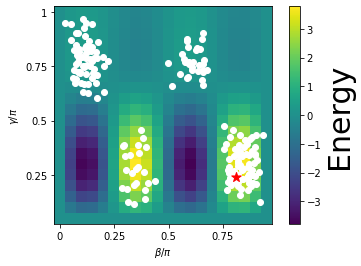

In [36]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1]%bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])

# Annealing

In [12]:
BASELINE_SHOTS

100

In [14]:
shots_per_point = BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=NPOPULATION,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = result2.fun
(result2.x, result2.fun)        

(array([4.2963322 , 0.74540004]), -3.0544084139822267)

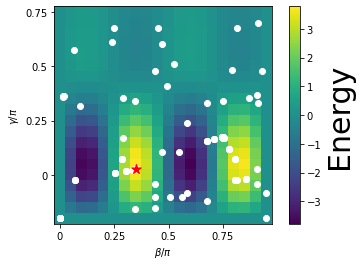

In [15]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
cb.set_label('Energy', fontsize=30)

Text(0, 0.5, 'Fraction of Points')

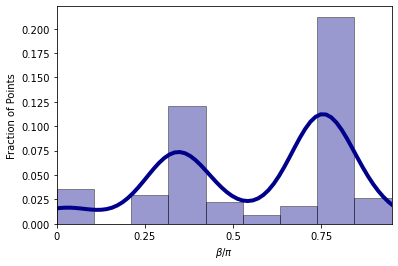

In [17]:
import seaborn as sns
sns.distplot(x2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,])
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\beta/\pi$")
plt.ylabel("Fraction of Points")

Text(0, 0.5, 'Fraction of Points')

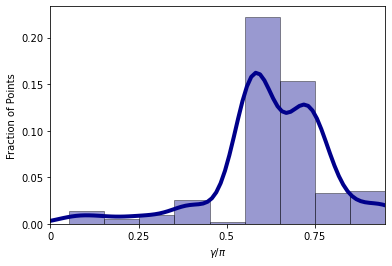

In [18]:
import seaborn as sns
sns.distplot(y2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,])
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\gamma/\pi$")
plt.ylabel("Fraction of Points")